In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

import os
import numpy as np
import matplotlib.pyplot as plt
import file_loading
from scipy.interpolate import Rbf
from multiprocessing import Pool
from astropy.io import ascii

from forecast import build_interp_zack
from forecast import findlevel
from forecast import plot_cube

In [9]:
nres = 20
computing_PS_flag = True
computing_PC_flag = False

### 1. PS/PC, cut at ellmax=5000, for single redshift (ngal40)

In [ ]:
%%time
output_cube_name = '1ngal40'
data_dir = '/home/zequnl/Projects/neutrino_mpk/'
table = ascii.read('parameters.table')

params, obsarr_PS, obsarr_PC, ell, kappa, invcov_PS, invcov_PC = \
                file_loading.get_data_arrays_across_redshifts( table,
                    data_dir = data_dir,
                    PS_directory = data_dir + 'powerspectrum_ngal40', 
                    PC_directory = data_dir + 'peakcounts_ngal40',
                    redshifts = ['10'])

# we overwrite the inverse covariance matrix with the new one
# NOTE: ngal40 requires a special string!
# invcov_PC = file_loading.compute_custom_PC_cov(  ['10'], 
#      fid_string='Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S_z10_cov_ngal40.npy')

    
# set up grid

x_PS = np.linspace(0.1 - 0.04, 0.1 + 0.13, nres) # M_nu
y_PS = np.linspace(0.3 - 0.012, 0.3 + 0.01, nres) # omega_m
z_PS = np.linspace(0.8295 - 0.012, 0.8295 + 0.016, nres) # sigma_8
X_PS, Y_PS, Z_PS = np.meshgrid(x_PS, y_PS, z_PS, indexing='ij')
input_param_list_PS = list(zip(np.ravel(X_PS), np.ravel(Y_PS), np.ravel(Z_PS)))

x_PC = np.linspace(0.1 - 0.01, 0.1 + 0.01, nres) # M_nu
y_PC = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres) # omega_m
z_PC = np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres) # sigma_8
X_PC, Y_PC, Z_PC = np.meshgrid(x_PC, y_PC, z_PC, indexing='ij')
input_param_list_PC = list(zip(np.ravel(X_PC), np.ravel(Y_PC), np.ravel(Z_PC)))

# ----- BOILER PLATE STUFF BEGINS HERE

# set up interpolator
interp_PS = build_interp_zack(obsarr_PS, params)
interp_PC = build_interp_zack(obsarr_PC, params)

def P_PS( parameter_input ):
    my_interp = interp_PS;
    my_invcov = invcov_PS
    my_fid_model = obsarr_PS[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

def P_PC( parameter_input ):
    my_interp = interp_PC
    my_invcov = invcov_PC
    my_fid_model = obsarr_PC[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

if __name__ == '__main__':
    if computing_PS_flag:
        pool = Pool(16)
        PS_cube = np.array(pool.map(P_PS, input_param_list_PS))
        PS_cube = PS_cube.reshape(X_PS.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PS.npy', PS_cube )
        np.save( 'cubes/' + output_cube_name + '_PS_xyz.npy', np.array([x_PS,y_PS,z_PS]) )
        
    if computing_PC_flag:
        pool = Pool(16)
        PC_cube = np.array(pool.map(P_PC, input_param_list_PC))
        PC_cube = PC_cube.reshape(X_PC.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PC.npy', PC_cube )
        np.save( 'cubes/' + output_cube_name + '_PC_xyz.npy', np.array([x_PC,y_PC,z_PC]) )

PS bins [24]
PC bins [184]
PS nr 1000 nb 24 0.974974974974975
PC nr 1000 nb 184 0.8148148148148148


### 2. PS/PC, cut at ellmax=5000, combining all 5 redshifts

In [10]:
%%time
output_cube_name = '5z_old'
data_dir = '/home/zequnl/Projects/neutrino_mpk/'
table = ascii.read('parameters.table')

params, obsarr_PS, obsarr_PC, ell, kappa, invcov_PS, invcov_PC = \
                file_loading.get_data_arrays_across_redshifts( table,
                    data_dir = data_dir,
                    PS_directory = data_dir + 'powerspectrum_noisy', 
                    PC_directory = data_dir + 'peakcounts_noisy',
                    redshifts = ['05', '10', '15', '20', '25'])
    
# we overwrite the inverse covariance matrix with the new one
# invcov_PC = file_loading.compute_custom_PC_cov(  ['05', '10', '15', '20', '11000'] )

# set up grid
x_PS = np.linspace(0.1 - 0.025, 0.1 + 0.025, nres) # M_nu
y_PS = np.linspace(0.3 - 0.005, 0.3 + 0.005, nres) # omega_m
z_PS = np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres) # sigma_8
X_PS, Y_PS, Z_PS = np.meshgrid(x_PS, y_PS, z_PS, indexing='ij')
input_param_list_PS = list(zip(np.ravel(X_PS), np.ravel(Y_PS), np.ravel(Z_PS)))

x_PC = np.linspace(0.1 - 0.01, 0.1 + 0.01, nres) # M_nu
y_PC = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres) # omega_m
z_PC = np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres) # sigma_8
X_PC, Y_PC, Z_PC = np.meshgrid(x_PC, y_PC, z_PC, indexing='ij')
input_param_list_PC = list(zip(np.ravel(X_PC), np.ravel(Y_PC), np.ravel(Z_PC)))

# ----- BOILER PLATE STUFF BEGINS HERE

# set up interpolator
interp_PS = build_interp_zack(obsarr_PS, params)
interp_PC = build_interp_zack(obsarr_PC, params)

def P_PS( parameter_input ):
    my_interp = interp_PS;
    my_invcov = invcov_PS
    my_fid_model = obsarr_PS[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

def P_PC( parameter_input ):
    my_interp = interp_PC
    my_invcov = invcov_PC
    my_fid_model = obsarr_PC[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

if __name__ == '__main__':
    if computing_PS_flag:
        pool = Pool(16)
        PS_cube = np.array(pool.map(P_PS, input_param_list_PS))
        PS_cube = PS_cube.reshape(X_PS.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PS.npy', PS_cube )
        np.save( 'cubes/' + output_cube_name + '_PS_xyz.npy', np.array([x_PS,y_PS,z_PS]) )
        
    if computing_PC_flag:
        pool = Pool(16)
        PC_cube = np.array(pool.map(P_PC, input_param_list_PC))
        PC_cube = PC_cube.reshape(X_PC.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PC.npy', PC_cube )
        np.save( 'cubes/' + output_cube_name + '_PC_xyz.npy', np.array([x_PC,y_PC,z_PC]) )

PS bins [24, 24, 24, 24, 24]
PC bins [200, 184, 170, 163, 159]
PS nr 1000 nb 120 0.8788788788788788
PC nr 1000 nb 876 0.12212212212212212
CPU times: user 26.7 s, sys: 1.67 s, total: 28.3 s
Wall time: 15 s


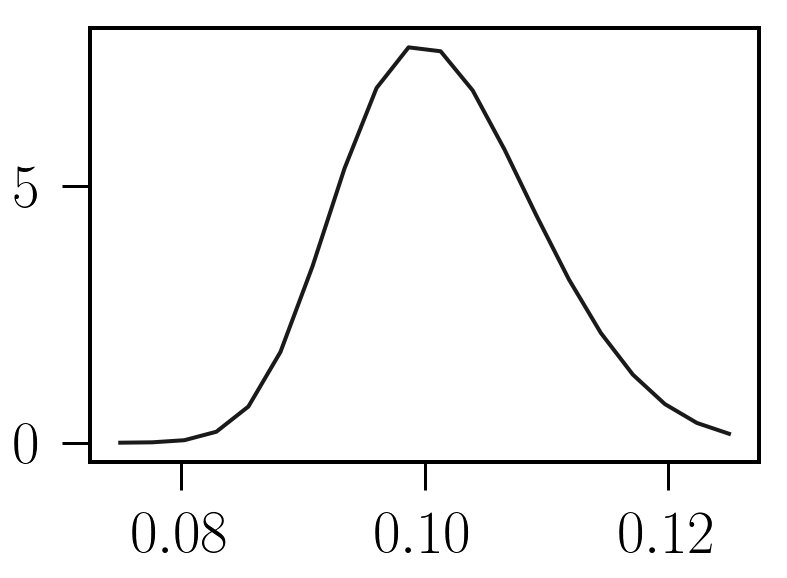

In [11]:
plt.plot( x_PS, np.sum(np.sum(PS_cube, axis=0), axis=0) )

# High $\ell$

In [ ]:
%%time
output_cube_name = '5z-highl'
data_dir = '/home/zequnl/Projects/neutrino_mpk/'
table = ascii.read('parameters.table')

params, obsarr_PS, obsarr_PC, ell, kappa, invcov_PS, invcov_PC = \
                file_loading.get_data_arrays_across_redshifts( table,
                    data_dir = data_dir,
                    PS_directory = data_dir + 'powerspectrum_noisy', 
                    PC_directory = data_dir + 'peakcounts_noisy',
                    redshifts = ['05', '10', '15', '20', '25'],
                    l_max = 10000)
    
# we overwrite the inverse covariance matrix with the new one
# invcov_PC = file_loading.compute_custom_PC_cov(  ['05', '10', '15', '20', '11000'] )


# set up grid - actually just inherit from above! this is commented out, 
# uncomment if you're running this cell alone
# x_PS = np.linspace(0.1 - 0.025, 0.1 + 0.025, nres) # M_nu
# y_PS = np.linspace(0.3 - 0.005, 0.3 + 0.005, nres) # omega_m
# z_PS = np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres) # sigma_8
# X_PS, Y_PS, Z_PS = np.meshgrid(x_PS, y_PS, z_PS, indexing='ij')
# input_param_list_PS = list(zip(np.ravel(X_PS), np.ravel(Y_PS), np.ravel(Z_PS)))

# x_PC = np.linspace(0.1 - 0.01, 0.1 + 0.01, nres) # M_nu
# y_PC = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres) # omega_m
# z_PC = np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres) # sigma_8
# X_PC, Y_PC, Z_PC = np.meshgrid(x_PC, y_PC, z_PC, indexing='ij')
# input_param_list_PC = list(zip(np.ravel(X_PC), np.ravel(Y_PC), np.ravel(Z_PC)))

# ----- BOILER PLATE STUFF BEGINS HERE

# set up interpolator
interp_PS = build_interp_zack(obsarr_PS, params)
interp_PC = build_interp_zack(obsarr_PC, params)

def P_PS( parameter_input ):
    my_interp = interp_PS;
    my_invcov = invcov_PS
    my_fid_model = obsarr_PS[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

def P_PC( parameter_input ):
    my_interp = interp_PC
    my_invcov = invcov_PC
    my_fid_model = obsarr_PC[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )


if __name__ == '__main__':
    if computing_PS_flag:
        pool = Pool(16)
        PS_cube = np.array(pool.map(P_PS, input_param_list_PS))
        PS_cube = PS_cube.reshape(X_PS.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PS.npy', PS_cube )
        np.save( 'cubes/' + output_cube_name + '_PS_xyz.npy', np.array([x_PS,y_PS,z_PS]) )
        
    if computing_PC_flag:
        pool = Pool(16)
        PC_cube = np.array(pool.map(P_PC, input_param_list_PC))
        PC_cube = PC_cube.reshape(X_PC.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PC.npy', PC_cube )
        np.save( 'cubes/' + output_cube_name + '_PC_xyz.npy', np.array([x_PC,y_PC,z_PC]) )

### 5 redshifts + CMB


In [ ]:
%%time
output_cube_name = '5zCMB'
data_dir = '/home/zequnl/Projects/neutrino_mpk/'
table = ascii.read('parameters.table')

params, obsarr_PS, obsarr_PC, ell, kappa, invcov_PS, invcov_PC = \
                file_loading.get_data_arrays_across_redshifts( table,
                    data_dir = data_dir,
                    PS_directory = data_dir + 'powerspectrum_noisy', 
                    PC_directory = data_dir + 'peakcounts_noisy',
                    redshifts = ['05', '10', '15', '20', '25', '11000'])
    
# we overwrite the inverse covariance matrix with the new one
# invcov_PC = file_loading.compute_custom_PC_cov(  ['05', '10', '15', '20', '11000'] )

# set up grid
x_PS = np.linspace(0.1 - 0.025, 0.1 + 0.025, nres) # M_nu
y_PS = np.linspace(0.3 - 0.005, 0.3 + 0.005, nres) # omega_m
z_PS = np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres) # sigma_8
X_PS, Y_PS, Z_PS = np.meshgrid(x_PS, y_PS, z_PS, indexing='ij')
input_param_list_PS = list(zip(np.ravel(X_PS), np.ravel(Y_PS), np.ravel(Z_PS)))

x_PC = np.linspace(0.1 - 0.01, 0.1 + 0.01, nres) # M_nu
y_PC = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres) # omega_m
z_PC = np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres) # sigma_8
X_PC, Y_PC, Z_PC = np.meshgrid(x_PC, y_PC, z_PC, indexing='ij')
input_param_list_PC = list(zip(np.ravel(X_PC), np.ravel(Y_PC), np.ravel(Z_PC)))

# ----- BOILER PLATE STUFF BEGINS HERE

# set up interpolator
interp_PS = build_interp_zack(obsarr_PS, params)
interp_PC = build_interp_zack(obsarr_PC, params)

def P_PS( parameter_input ):
    my_interp = interp_PS;
    my_invcov = invcov_PS
    my_fid_model = obsarr_PS[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

def P_PC( parameter_input ):
    my_interp = interp_PC
    my_invcov = invcov_PC
    my_fid_model = obsarr_PC[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

if __name__ == '__main__':
    if computing_PS_flag:
        pool = Pool(16)
        PS_cube = np.array(pool.map(P_PS, input_param_list_PS))
        PS_cube = PS_cube.reshape(X_PS.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PS.npy', PS_cube )
        np.save( 'cubes/' + output_cube_name + '_PS_xyz.npy', np.array([x_PS,y_PS,z_PS]) )
        
    if computing_PC_flag:
        pool = Pool(16)
        PC_cube = np.array(pool.map(P_PC, input_param_list_PC))
        PC_cube = PC_cube.reshape(X_PC.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PC.npy', PC_cube )
        np.save( 'cubes/' + output_cube_name + '_PC_xyz.npy', np.array([x_PC,y_PC,z_PC]) )

### lever
How much of a lever arm is redshift tomography?

In [5]:
%%time
output_cube_name = 'lever1'
data_dir = '/home/zequnl/Projects/neutrino_mpk/'
table = ascii.read('parameters.table')

params, obsarr_PS, obsarr_PC, ell, kappa, invcov_PS, invcov_PC = \
                file_loading.get_data_arrays_across_redshifts( table,
                    data_dir = data_dir,
                    PS_directory = data_dir + 'powerspectrum_noisy', 
                    PC_directory = data_dir + 'peakcounts_noisy',
                    redshifts = ['05', '25'])
    
# we overwrite the inverse covariance matrix with the new one
# invcov_PC = file_loading.compute_custom_PC_cov(  ['05', '10', '15', '20', '11000'] )

# set up grid
x_PS = np.linspace(0.1 - 0.04, 0.1 + 0.13, nres) # M_nu
y_PS = np.linspace(0.3 - 0.012, 0.3 + 0.01, nres) # omega_m
z_PS = np.linspace(0.8295 - 0.012, 0.8295 + 0.016, nres) # sigma_8
X_PS, Y_PS, Z_PS = np.meshgrid(x_PS, y_PS, z_PS, indexing='ij')
input_param_list_PS = list(zip(np.ravel(X_PS), np.ravel(Y_PS), np.ravel(Z_PS)))

x_PC = np.linspace(0.1 - 0.01, 0.1 + 0.01, nres) # M_nu
y_PC = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres) # omega_m
z_PC = np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres) # sigma_8
X_PC, Y_PC, Z_PC = np.meshgrid(x_PC, y_PC, z_PC, indexing='ij')
input_param_list_PC = list(zip(np.ravel(X_PC), np.ravel(Y_PC), np.ravel(Z_PC)))

# ----- BOILER PLATE STUFF BEGINS HERE

# set up interpolator
interp_PS = build_interp_zack(obsarr_PS, params)
interp_PC = build_interp_zack(obsarr_PC, params)

def P_PS( parameter_input ):
    my_interp = interp_PS;
    my_invcov = invcov_PS
    my_fid_model = obsarr_PS[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

def P_PC( parameter_input ):
    my_interp = interp_PC
    my_invcov = invcov_PC
    my_fid_model = obsarr_PC[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

if __name__ == '__main__':
    if computing_PS_flag:
        pool = Pool(16)
        PS_cube = np.array(pool.map(P_PS, input_param_list_PS))
        PS_cube = PS_cube.reshape(X_PS.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PS.npy', PS_cube )
        np.save( 'cubes/' + output_cube_name + '_PS_xyz.npy', np.array([x_PS,y_PS,z_PS]) )
        
    if computing_PC_flag:
        pool = Pool(16)
        PC_cube = np.array(pool.map(P_PC, input_param_list_PC))
        PC_cube = PC_cube.reshape(X_PC.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PC.npy', PC_cube )
        np.save( 'cubes/' + output_cube_name + '_PC_xyz.npy', np.array([x_PC,y_PC,z_PC]) )

PS bins [24, 24]
PC bins [200, 159]
PS nr 1000 nb 48 0.950950950950951
PC nr 1000 nb 359 0.6396396396396397


NameError: name 'computing_PC_flag' is not defined

In [8]:
%%time
output_cube_name = 'lever2'
data_dir = '/home/zequnl/Projects/neutrino_mpk/'
table = ascii.read('parameters.table')

params, obsarr_PS, obsarr_PC, ell, kappa, invcov_PS, invcov_PC = \
                file_loading.get_data_arrays_across_redshifts( table,
                    data_dir = data_dir,
                    PS_directory = data_dir + 'powerspectrum_noisy', 
                    PC_directory = data_dir + 'peakcounts_noisy',
                    redshifts = ['05', '10'])

# we overwrite the inverse covariance matrix with the new one
# invcov_PC = file_loading.compute_custom_PC_cov(  ['05', '10', '15', '20', '11000'] )

# set up grid
x_PS = np.linspace(0.1 - 0.04, 0.1 + 0.13, nres) # M_nu
y_PS = np.linspace(0.3 - 0.012, 0.3 + 0.01, nres) # omega_m
z_PS = np.linspace(0.8295 - 0.012, 0.8295 + 0.016, nres) # sigma_8
X_PS, Y_PS, Z_PS = np.meshgrid(x_PS, y_PS, z_PS, indexing='ij')
input_param_list_PS = list(zip(np.ravel(X_PS), np.ravel(Y_PS), np.ravel(Z_PS)))

x_PC = np.linspace(0.1 - 0.01, 0.1 + 0.01, nres) # M_nu
y_PC = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres) # omega_m
z_PC = np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres) # sigma_8
X_PC, Y_PC, Z_PC = np.meshgrid(x_PC, y_PC, z_PC, indexing='ij')
input_param_list_PC = list(zip(np.ravel(X_PC), np.ravel(Y_PC), np.ravel(Z_PC)))

# ----- BOILER PLATE STUFF BEGINS HERE

# set up interpolator
interp_PS = build_interp_zack(obsarr_PS, params)
interp_PC = build_interp_zack(obsarr_PC, params)

def P_PS( parameter_input ):
    my_interp = interp_PS;
    my_invcov = invcov_PS
    my_fid_model = obsarr_PS[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

def P_PC( parameter_input ):
    my_interp = interp_PC
    my_invcov = invcov_PC
    my_fid_model = obsarr_PC[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

if __name__ == '__main__':
    if computing_PS_flag:
        pool = Pool(16)
        PS_cube = np.array(pool.map(P_PS, input_param_list_PS))
        PS_cube = PS_cube.reshape(X_PS.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PS.npy', PS_cube )
        np.save( 'cubes/' + output_cube_name + '_PS_xyz.npy', np.array([x_PS,y_PS,z_PS]) )
        
    if computing_PC_flag:
        pool = Pool(16)
        PC_cube = np.array(pool.map(P_PC, input_param_list_PC))
        PC_cube = PC_cube.reshape(X_PC.shape)
        pool.close()
        np.save( 'cubes/' + output_cube_name + '_PC.npy', PC_cube )
        np.save( 'cubes/' + output_cube_name + '_PC_xyz.npy', np.array([x_PC,y_PC,z_PC]) )

PS bins [24, 24]
PC bins [200, 184]
PS nr 1000 nb 48 0.950950950950951
PC nr 1000 nb 384 0.6146146146146146
CPU times: user 18 s, sys: 924 ms, total: 18.9 s
Wall time: 33.2 s
